In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from helpers import *

### Distortion

[[100.]
 [220.]
 [  1.]]
[[600.    0.  400.  600. ]
 [  0.  600.  400.  720. ]
 [  0.    0.    1.    1.5]]


820.0

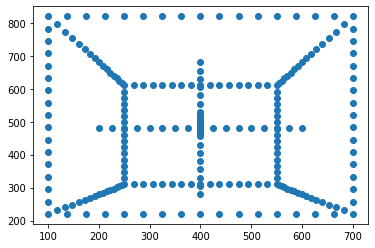

In [3]:
Q = getcube(16)
f = 600
alpha = 1
beta = 0
deltax = deltay = 400
K = build_K(f,alpha,beta,deltax,deltay)
theta = np.pi / 3
R = np.eye(3)
# R = np.array([
#     [np.cos(theta), 0, np.sin(theta)],
#     [0, 1, 0],
#     [-np.sin(theta), 0, np.cos(theta)],
# ])
t = np.array([[0,.2,1.5]]).T
(ppsx,ppsy) = projectpoints(K,R,t,Q,printP=True)
plt.scatter(ppsx, ppsy) # 2D image
max(ppsy) # this is out of image sensor 

[[120.4 ]
 [232.24]
 [  1.  ]]


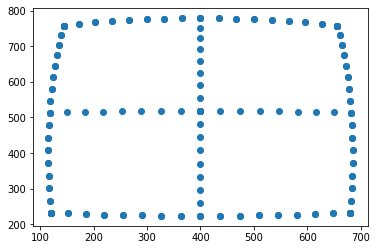

In [4]:
# slides math
# TODO: why it's not projected as cube ?
def projectpoints_dist(K, R, t, Q, dist):
    Q.reshape((Q.shape[1],Q.shape[0]))
    T = np.concatenate((R,t),axis=1)
    ppsx = []
    ppsy = []
    for i in range(Q.shape[0]):
        Qi = Q[i,:].copy()
        pid = T @ Qi.reshape(4,1)
        pid = pid[:2]
        pid = pid * (1 - .2*np.linalg.norm(pid,2)**2)
        pid = np.append(pid,np.ones((1,1)),axis=0)
        projected = K @ pid
        if (Qi == np.array([-0.5, -0.5, -0.5, 1.0])).all():
            print(projected/projected[2])
        ppsx.append(float(projected[0]/projected[2]))
        ppsy.append(float(projected[1]/projected[2]))
    return ppsx,ppsy

dist_coeffs = [1.0,2.0,3.0]
(ppsx,ppsy) = projectpoints_dist(K,R,t,Q,dist_coeffs)
plt.scatter(ppsx, ppsy) # 2D image

[[875.00544   0.      960.     ]
 [  0.      875.00544 540.     ]
 [  0.        0.        1.     ]]


(None, [-0.245031, 0.071524, -0.00994978])

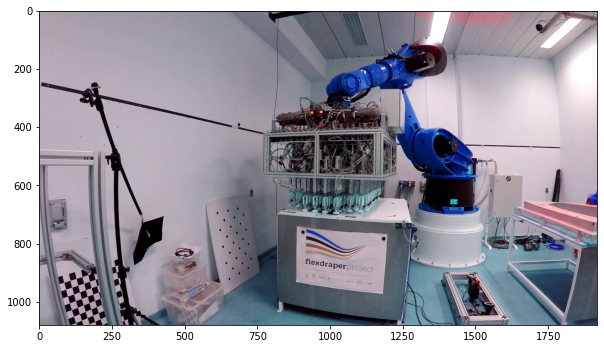

In [25]:
im = cv2.imread('data/gopro_robot.jpg')
plt.figure(1, figsize=(10,10))
plt.imshow(im)
height,width,_ = im.shape
f = width*0.455732
deltax = height/2
deltay = width/2
k3 = -0.245031
k5 = 0.071524
k7 = -0.00994978
dist_coeffs = [k3,k5,k7]
K = build_K(f,alpha,beta,deltay,deltax)
print(K),dist_coeffs

(<matplotlib.image.AxesImage at 0x1c55cb69fd0>,
 array([[460.35739136,   0.        , 959.4999904 ],
        [  0.        , 613.56103516, 539.49997491],
        [  0.        ,   0.        ,   1.        ]]),
 array([[875.00544,   0.     , 960.     ],
        [  0.     , 875.00544, 540.     ],
        [  0.     ,   0.     ,   1.     ]]))

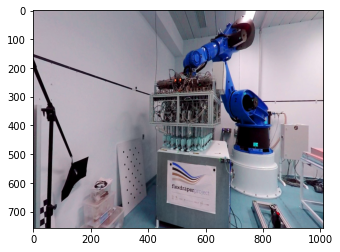

In [28]:
im = cv2.imread('data/gopro_robot.jpg')
# im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
h, w = im.shape[:2]
# k_1, k_2, p_1, p_2[, k_3[, k_4, k_5, k_6 [, s_1, s_2, s_3, s_4[, \\tau_x, \\tau_y
dist_coeffs = np.array([k3,k5,0,0,k7])
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(K, dist_coeffs, (w,h), 1, (w,h))
dst = cv2.undistort(im, K, dist_coeffs, None, newcameramtx)
x, y, w, h = roi
dst = dst[y:y+h, x:x+w]
plt.imshow(dst), newcameramtx, K

(1079, 1919, (1080, 1920, 3), (1080, 1920))

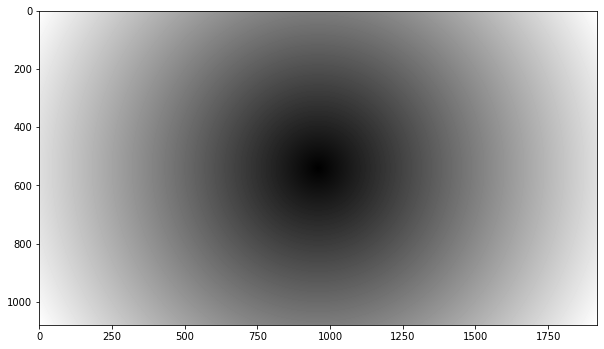

In [7]:
data = im
center = [deltay,deltax]
y, x = np.indices((data.shape[:2]))
r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
y = y.astype(np.float64)
ym = y.max()
y /= y.max()
x = x.astype(np.float64)
xm = x.max()
x /= x.max()
r /= r.max()
plt.figure(2, figsize=(10,10))
plt.imshow(r, cmap='gray')

dr = np.zeros_like(r)       
for i,d in enumerate(dist_coeffs):
    dr += d*r**((i+1)*2)
    
yd = ((y * (1+dr)) * ym).astype(np.int16)
xd = ((x * (1+dr)) * xm).astype(np.int16)
yd.max(),xd.max(),im.shape,yd.shape

### Homographies

In [9]:
H = np.array([
    [-2,0,1],
    [1,-2,0],
    [0,0,3],
])
def gq(p):
    q=H@p
    return q/q[-1]

p1 = np.ones((3,1))
q1 = gq(p1)
p2 = np.array([[0],[3],[1]])
q2 = gq(p2)
p3 = np.array([[2],[3],[1]])
q3 = gq(p3)
p4 = np.array([[2],[4],[1]])
q4 = gq(p4)

# q1h = H@p1
# q2h = H@p2
# q1 = q1h/q1h[-1]
# q2 = q2h/q2h[-1]
Q1 = np.concatenate((p1,p2,p3,p4),axis=1).T
Q2 = np.concatenate((q1,q2,q3,q4),axis=1).T

In [10]:
def hest(q1,q2):
    # i have to store there normalization 
    # params for later use of homography!
    # TODO:
    # q1[:,:2] = normalize2d(q1[:,:2])
    # q2[:,:2] = normalize2d(q2[:,:2])
    Bs = []
    for p,q in zip(q1,q2):
        B = np.kron(p,np.cross(q, np.identity(q.shape[0]) * -1))
        Bs.append(B)
    U,S,V = np.linalg.svd(np.concatenate(Bs,axis=0))
    He = V[-1].reshape(3,3).round(3).T
    return He

t = hest(Q1,Q2)@p1
t = t[:-1]/t[-1]
t

array([[-0.33430233],
       [-0.33430233]])

In [11]:
hest(Q1,Q2)

array([[ 0.459,  0.   , -0.229],
       [-0.229,  0.459,  0.   ],
       [ 0.   , -0.   , -0.688]])